In [1]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)

from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML
import pyro.distributions as dist

import swyft

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')
imkwargs2 = dict(extent=(-2.5, 2.5))

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *

from matplotlib.colors import LogNorm

In [2]:
SYSTEM_NAME = "ngc4414"
NSIM = 100
SIM_PATH = f'store_2.zarr' 

SIGMA = 0.1

### Utilities

In [3]:
def get_config(system_name: str, config_name: str = 'config_sub.yaml') -> Clipppy:
    """
    Get configuration
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

    SOURCE_DIR = '../../mock_data/sources'
        
    source_name = f'{system_name}.npy'
    config = load_config(config_name, base_dir=SOURCE_DIR)

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return config


def get_prior(config: Clipppy):
    """
    Set up subhalo parameter priors using a config
    """
    main = config.umodel.alphas["main"]
    prior_p_sub = main.sub.pos_sampler.base_dist
    lows = np.array(
        [
            prior_p_sub.low[0].item(),
            prior_p_sub.low[1].item(),
        ]
    )
    highs = np.array(
        [
            prior_p_sub.high[0].item(),
            prior_p_sub.high[1].item(),
        ]
    )
    
#     print(lows)
#     print(highs)
    
    return swyft.Prior(lambda u: (highs - lows) * u + lows, 2)


def simul(v, config: Clipppy):
    """
    Fix values for main lens and source parameters from config and put
    in a subhalo with the specified position and mass.

    Arguments
    - v: array containing x_sub, y_sub.

    Returns
    - Numpy array.
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
    
    from pyrofit.lensing.utils import get_meshgrid  # import here due to HACKs
    nx = config.kwargs["defs"]["nx"]
    ny = config.kwargs["defs"]["ny"]
    res = config.kwargs["defs"]["res"]
    X, Y = config.umodel.X.clone(), config.umodel.Y.clone()
    # Upsample image
    upsample = 10
    config.umodel.coerce_XY(*get_meshgrid(res / upsample, nx * upsample, ny * upsample))
        
    x_sub, y_sub = np.squeeze(v.T)
    d_p_sub = dist.Delta(torch.tensor([x_sub, y_sub])).to_event(1)

    def _guide():
        # Sample subhalo position
        guide_sample = {
            "main/sub/p_sub": pyro.sample("main/sub/p_sub", d_p_sub),
        }

        return guide_sample
    
    result = {
        "image": CONFIG.ppd(guide=_guide)["model_trace"]
        .nodes["mu"]["value"]
        .detach()
        .numpy()
    }
    
    # Restore coarse grid
    config.umodel.coerce_XY(X, Y)
    # Downsample image
    averager = torch.nn.AvgPool2d((upsample, upsample))
    result['image'] = (averager(torch.tensor(result['image']).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0))

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return result

def noise(obs, _=None, sigma_n=SIGMA):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}


### Check utilities

In [4]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK # rest is using this
CONFIG = get_config(SYSTEM_NAME)
torch.set_default_tensor_type(torch.FloatTensor) # swyft is using this

In [5]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK # rest is using this
CONFIG_X = get_config(SYSTEM_NAME, 'config_sub_x.yaml')

try:
    print( CONFIG.umodel.alphas['main'].sub.pos_sampler )
except:
    print('CONFIG does no have a sub')
    
try:
    print( CONFIG_X.umodel.alphas['main'].sub.pos_sampler )
except:
    print('CONFIG_X does no have a sub')
    
model = CONFIG.umodel
model_x = CONFIG_X.umodel
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK # rest is using this

Independent(Uniform(low: torch.Size([2]), high: torch.Size([2])), 1)
CONFIG_X does no have a sub


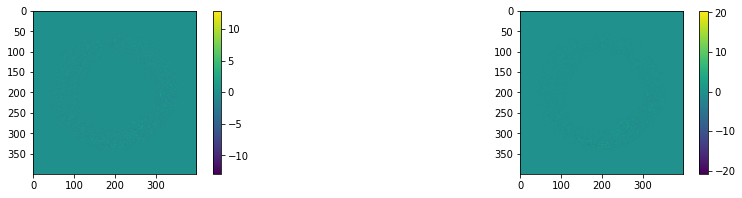

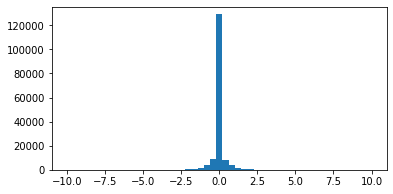

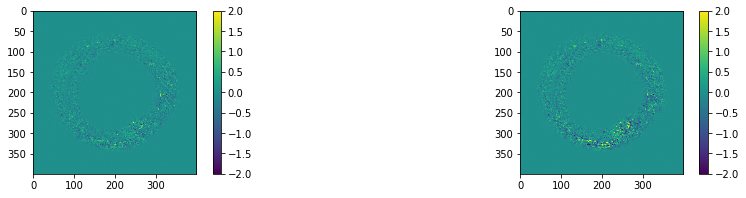

In [6]:
plots = [model() - model_x(), model() - model_x()]
plot_imshow(plots, size_y = 3, colorbar = True)

plt.figure(figsize = (6, 3))
plt.hist(plots[0].flatten().detach().numpy(), bins = np.linspace(-10, 10))
plt.show()

vm = 2
plot_imshow(plots, size_y = 3, colorbar = True, vmin = -vm, vmax = vm)

In [7]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
ppd = CONFIG.ppd()['model_trace'].nodes
ppd1 = CONFIG.ppd()['model_trace'].nodes
ppd2 = CONFIG.ppd()['model_trace'].nodes
ppd3 = CONFIG.ppd()['model_trace'].nodes
ppds = [ppd1, ppd2, ppd3]
torch.set_default_tensor_type(torch.FloatTensor)

`Xsrc` and `Ysrc`: one of the points in difference is the subhalo position of `i`, the other point is the subhalo position of `j`

`image` and `mu`: difference is Gaussian noise. See some residue of lens itself because Gaussian noise is dependent on `mu` at that pixel.

###### Xsrc #####


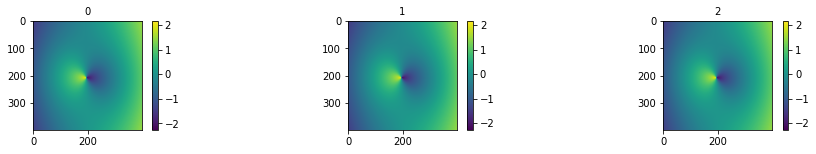

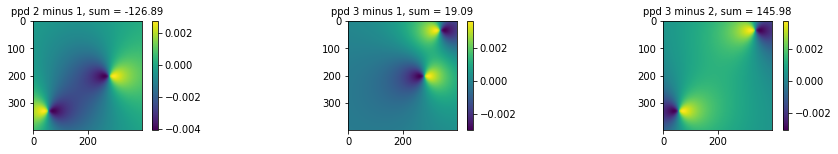

###### Ysrc #####


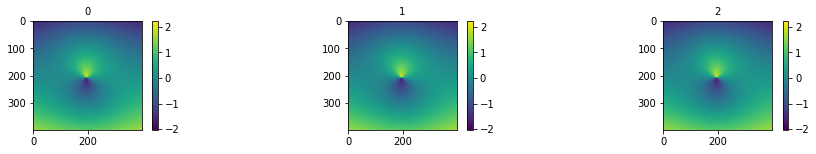

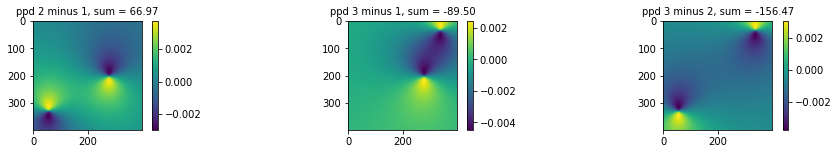

###### image #####


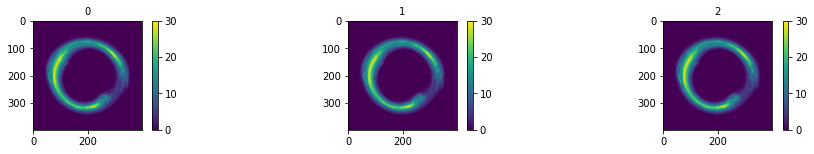

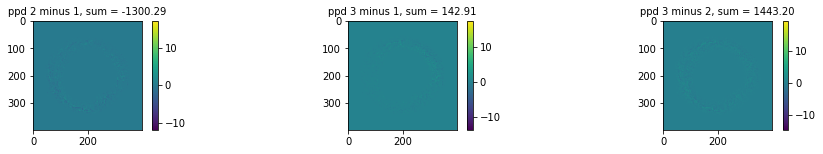

###### mu #####


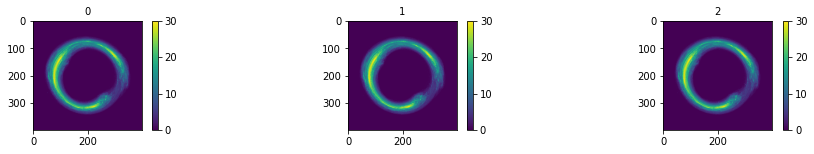

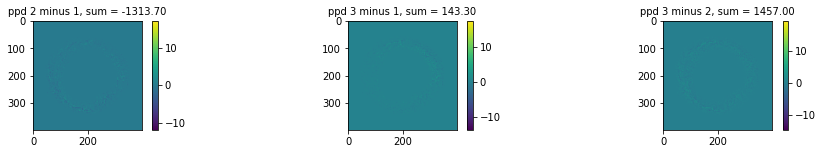

In [8]:
size_y = 2
for k, log in zip(['Xsrc', 'Ysrc', 'image', 'mu'], [False, False, False, False]):
    print(f'###### {k} #####')
    
    
    diffs = ([])
    titles_diff = ([])
    titles = ([])
    
    for i in range(len(ppds)):
        for j in range(i):
            diff = ppds[i][k]['value'] - ppds[j][k]['value']
            diffs.append(ppds[i][k]['value'] - ppds[j][k]['value'])
            titles_diff.append(f'ppd {i+1} minus {j+1}, sum = {torch.sum(diff):.2f}')
        titles.append(i)
            
    
    plots = [ppd[k]['value'] for ppd in ppds]

        
        
    plot_imshow(plots, titles = titles, size_y = size_y, colorbar = True)
    
    if log: plot_imshow(diffs, norm = LogNorm(), colorbar = True, titles = titles_diff, size_y = size_y)
    else: plot_imshow(diffs, colorbar = True, titles = titles_diff, size_y = size_y)
    


In [9]:
for k in ['main/sub/m_sub', 'main/sub/p_sub']:
    print(f'### {k} ###')
    for p in ppds:
        print(p[k]['value'])
    print()

### main/sub/m_sub ###
tensor([1.0000e+09], device='cuda:0')
tensor([1.0000e+09], device='cuda:0')
tensor([1.0000e+09], device='cuda:0')

### main/sub/p_sub ###
tensor([[0.9921, 0.0289]], device='cuda:0')
tensor([[-1.7889,  1.6261]], device='cuda:0')
tensor([[ 1.7361, -2.0728]], device='cuda:0')



In [10]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
ppd_x = CONFIG_X.ppd()['model_trace'].nodes
ppds = [ppd_x, ppd]
torch.set_default_tensor_type(torch.FloatTensor)

###### Xsrc #####


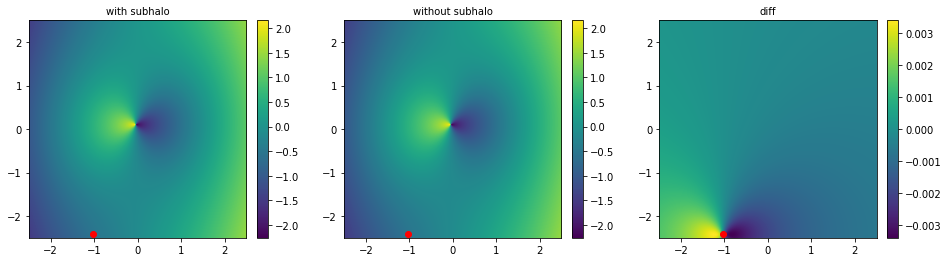

###### Ysrc #####


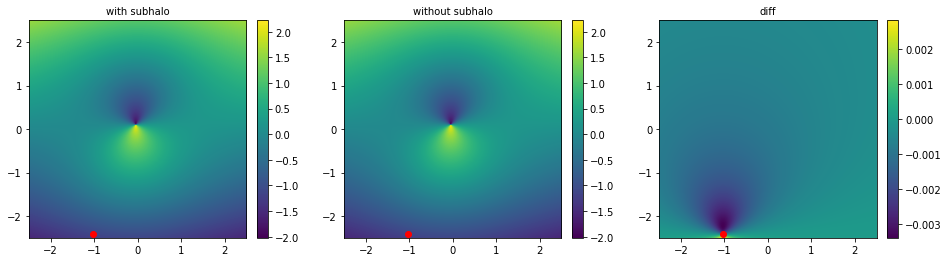

###### image #####


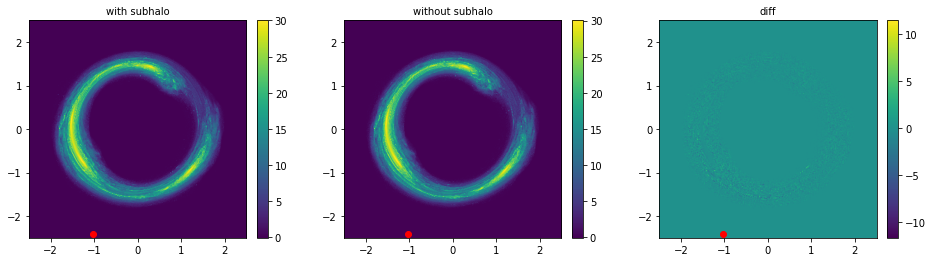

###### mu #####


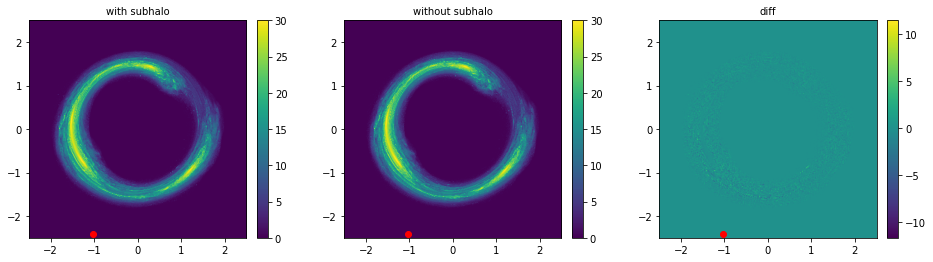

In [11]:
def plot_subhalo(plots, nrows = 1, size_x = 16, size_y = 8, 
                cmap = [None], titles = None, colorbar = False, single_colorbar = False, v = None, **args):
    """
    plots: list of what should be platted
    nrows: number of rows
    colobar: if True, a colorbar on each plot is plotted
    size_x, size_y: figsize = (size_x, size_y)
    """
    
    ncols = len(plots) // nrows
    N = len(plots)
    if len(cmap): cmap = cmap*N
        
    
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x, size_y))
    
    if ncols == 1:
        axes_flattened = [axes]
    else:
        axes_flattened = axes.flatten()
    
    
    for ax, plot, i in zip(axes_flattened, plots, range(N)):
        im = ax.imshow(plot, cmap = cmap[i], **args)
        if v != None:
            ax.scatter(*v.t(), c="r")
        if titles != None:
            ax.set_title(titles[i], fontsize = 10)
        if colorbar == True:
            fig.colorbar(im, fraction=0.046, pad=0.04, ax = ax)
#     plt.tight_layout()
    plt.show()

size_y = 4
for k in ['Xsrc', 'Ysrc', 'image', 'mu']:
    print(f'###### {k} #####')
    plots = [ppd[k]['value'], ppd_x[k]['value'], ppd[k]['value'] - ppd_x[k]['value']]
    titles = ['with subhalo', 'without subhalo', 'diff']
    v = ppd['main/sub/p_sub']['value']
    plot_subhalo(plots, titles = titles, size_y = size_y, colorbar = True, v = v, **imkwargs)

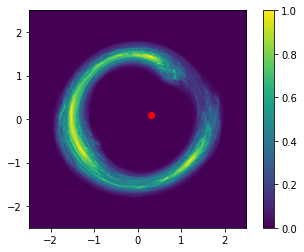

In [12]:
v = torch.tensor([0.3, 0.1]) # just a check, not adding a 'true' value or something
plt.imshow(simul(v, CONFIG)['image'], **imkwargs)
plt.scatter(*v.t(), c="r")
plt.colorbar()
plt.show()

### Simulate

In [13]:
prior = get_prior(CONFIG)
nx = CONFIG.kwargs["defs"]["nx"]
ny = CONFIG.kwargs["defs"]["ny"]

As one can see below, all values outside [0,1] are going to infinity. That part (tab[5000:7000]) is being mapped with the Prior $y = (2.5 - -2.5)\times u - 2.5 = 5\times u - 2.5$

/scratch/ipykernel_25202/4127013854.py:13: RuntimeWarning: invalid value encountered in subtract
  tab, v.T[0] - v.T[1], [x.T[0], p(x).T[0]]]


plot 5 is a tuple!


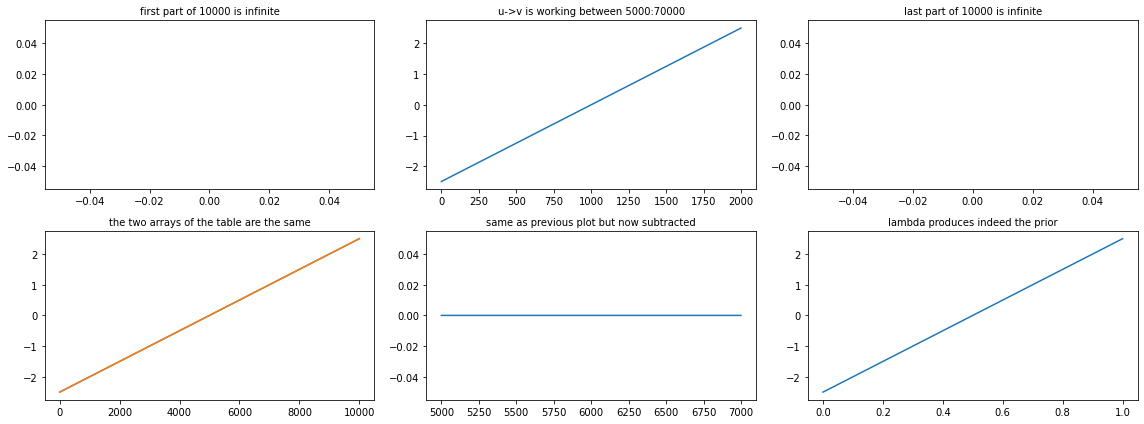

In [14]:
# Table and u->v from prior
tab = prior._table.T
v = prior.v(tab)
v0 = v.T[0] 

# Own lambda producing prior?
lows = np.array([-2.5, -2.5])
highs = np.array([2.5, 2.5])
p = lambda u: (highs - lows) * u + lows
x = np.linspace((0,0), (1,1))

plots = [v0[0:5000], v0[5000:7000], v0[7000:10000], 
         tab, v.T[0] - v.T[1], [x.T[0], p(x).T[0]]]

titles = ['first part of 10000 is infinite', 'u->v is working between 5000:70000', 'last part of 10000 is infinite', 
          'the two arrays of the table are the same', 'same as previous plot but now subtracted', 'lambda produces indeed the prior']
plot_plot(plots, nrows = 2, size_y = 6, titles = titles)

# print(v0[4990:5010])
# print(v0[6990:7010])
# print([np.sum(plot) for plot in plots])

In [15]:
SIM_PATH

'store_2.zarr'

In [16]:
simulator = swyft.Simulator(model = lambda v: simul(v, CONFIG), 
                            pnames = ["x_sub", "y_sub"],
                            sim_shapes={"image": (nx, ny)})

store = swyft.DirectoryStore(path=SIM_PATH, simulator=simulator)
 
store.add(NSIM, prior)
store.simulate()

Creating new store.
Store: Adding 98 new samples to simulator store.


In [17]:
store_x = ppd_x['image']['value'].detach().numpy()

### Check store

In [18]:
store = swyft.DirectoryStore(path=SIM_PATH)
len(store)

Loading existing store.


98

difference is because of subhalos

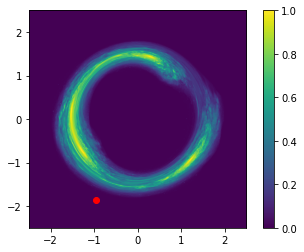

In [19]:
idx = 1 # because of __getitem__
plt.imshow(store[idx][0]['image'], **imkwargs)
plt.scatter(*store[idx][1], c="r")
plt.colorbar()

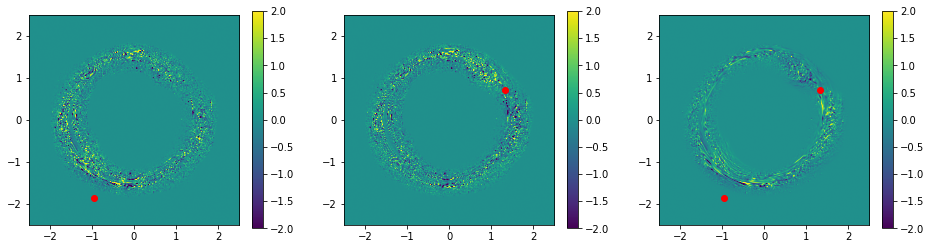

In [20]:
fig, axs = plt.subplots(1, 3, figsize = (16,4))

im = axs[0].imshow(store[1][0]['image']-store_x, vmin = -2, vmax = 2, **imkwargs)
axs[0].scatter(*store[1][1], c="r")
plt.colorbar(im, ax = axs[0])

im = axs[1].imshow(store[-1][0]['image']-store_x, vmin = -2, vmax = 2, **imkwargs)
axs[1].scatter(*store[-1][1], c="r")
plt.colorbar(im, ax = axs[1])

im = axs[2].imshow(store[1][0]['image']-store[-1][0]['image'], vmin = -2, vmax = 2, **imkwargs) # just a check
axs[2].scatter(*store[1][1], c="r")
axs[2].scatter(*store[-1][1], c="r")
plt.colorbar(im, ax = axs[2])

plt.show()

### Train

In [21]:
class DownsampleLinearHead(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        image_shape = obs_shapes["image"]
        self.onl_f = swyft.networks.OnlineNormalizationLayer(
            image_shape, use_average_std=False
        )

        self.factor = 8
        downscaled_image_shape = (
            image_shape[0] // self.factor,
            image_shape[1] // self.factor,
        )
        self.avg2d = torch.nn.AvgPool2d((self.factor, self.factor))

        self.n_features = 8
        self.layers = torch.nn.Linear(np.prod(downscaled_image_shape), self.n_features)

    def forward(self, obs):
        x = obs["image"]
        nbatch = len(x)
        x = self.onl_f(x)
        x = self.avg2d(x.unsqueeze(1)).squeeze(1)
        x = self.layers(x.view(nbatch, -1))
        return x

In [22]:
dataset = swyft.Dataset(NSIM, prior, store, simhook = noise)
post = swyft.Posteriors(dataset)

In [23]:
marginals = [(0, 1)]  #, (0,), (1,)]
post.add(
        marginals,
        head=DownsampleLinearHead,
        device="cuda",
    )

post.train(marginals)

Training: lr=0.001, Epoch=1, VL=1.386

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=2, VL=1.386

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=3, VL=1.386

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=4, VL=1.386

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=5, VL=1.386

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=6, VL=1.385

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=7, VL=1.384

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=8, VL=1.382

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=9, VL=1.38

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=10, VL=1.378

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=11, VL=1.372

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=12, VL=1.368

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=13, VL=1.359

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=14, VL=1.349

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=15, VL=1.336

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=16, VL=1.32

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=17, VL=1.305

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=18, VL=1.281

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=19, VL=1.255

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=20, VL=1.224

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=21, VL=1.192

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=22, VL=1.151

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=23, VL=1.103

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=24, VL=1.055

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=25, VL=0.9971

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=26, VL=0.9554

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=27, VL=0.9123

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=28, VL=0.8436

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=29, VL=0.7858

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Training: lr=0.001, Epoch=30, VL=0.7055


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [24]:
net = 'net_2.pt'
post.save(net)
# post = swyft.Posteriors.load(net).to('cuda')

post = swyft.Posteriors.load(net).to('cuda')

### Check posteriors

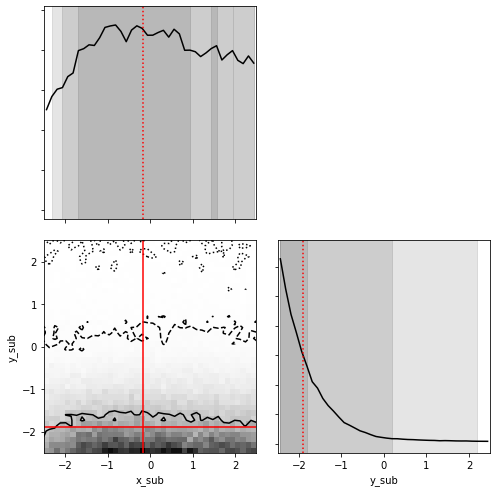

In [25]:
torch.set_default_tensor_type(torch.FloatTensor)  # HACK
idx = 5 # choose different observation 
IMAGE = store[idx][0]["image"]
v0 = store[idx][1]
samples = post.sample(100000, {"image": IMAGE})

swyft.plot_corner(
    samples, 
    [0, 1], 
    color='k', 
    figsize = (8,8), 
    truth=v0, 
    bins = 40);

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK